Step 1: Load torch and Cuda.

In [ ]:
pip install kornia
#CUDA 13.0 build of Torch
!pip3 install torch torchvision --index-url https://download.pytorch.org/whl/cu130 
pip install tqdm

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/1.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.1 MB ? eta -:--:--
   ---------------------------- ----------- 0.8/1.1 MB 4.7 MB/s eta 0:00:01
   ---------------------------------------- 1.1/1.1 MB 4.2 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.5 MB ? eta -:--:--
   ------------------------------------- -- 2.4/2.5 MB 11.6 MB/s eta 0:00:01
   ---------------------------------------- 2.5/2.5 MB 9.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import torch
import torchvision.models as models
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
import random
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from tqdm import tqdm
import zipfile
import requests
import os
import time

ModuleNotFoundError: No module named 'tqdm'

In [25]:
print("CUDA available:", torch.cuda.is_available())
print("Device:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")

CUDA available: True
Device: NVIDIA GeForce RTX 4070 Laptop GPU


Step 2: Load resnet 18    

In [ ]:
# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pretrained ResNet-18
model = models.resnet18(pretrained=True)
model.eval()  # Set to evaluation mode
model = model.to(device)  # Move model to GPU

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Step 3 (Optional) Test resnet 18 on imagenet mini validation.

In [6]:
#Substep 1: Define a transform to change dataset to expected input for resnet18

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
transformTest = transforms.Compose([
    transforms.ToTensor()
])

In [ ]:

if(os.path.isdir("imagenet-mini")):
        print("The dataset folder is already present.")
else:
    imageNetMiniUrl = "https://www.kaggle.com/api/v1/datasets/download/ifigotin/imagenetmini-1000"
    output_filename = "imagenet-mini.zip"
    try:
        with requests.get(imageNetMiniUrl,stream=True) as r:
            r.raise_for_status()
            total_size = int(r.headers.get('Content-Length',0))
            if os.path.exists(output_filename) and os.path.getsize(output_filename) >= total_size:
                print(f"The file is already found with a file size of {os.path.getsize(output_filename)}")
                r.close()
            else:
                with open(output_filename,"wb") as f,tqdm(total=total_size,unit='B',unit_scale=True) as progress_bar:
                    for chunk in r.iter_content():
                        r.raise_for_status()
                        if(chunk):
                            f.write(chunk)
                            progress_bar.update(len(chunk))
    except requests.exceptions.HTTPError as e:
        print(f'Error during download process: {e}')
    except requests.exceptions.RequestException as e:
            print(f"Error during query request: {e}")
    except IOError as e:
            print(f"Error writing file: {e}")

    with zipfile.ZipFile(output_filename) as z:
        z.printdir()
        z.extractall('.')



: 

In [7]:
val_dataset = ImageFolder(root='imagenet-mini/val', transform=transform)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
train_dataset = ImageFolder(root='imagenet-mini/train', transform=transformTest)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)


In [40]:
#Substep 3: Calculate the accuracy
top1_correct = 0
top5_correct = 0
total = 0

model.eval()
with torch.no_grad():
    for images, labels in tqdm(val_loader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)

        # Top-1 accuracy
        _, top1_pred = outputs.topk(1, dim=1)
        top1_correct += (top1_pred.squeeze() == labels).sum().item()

        # Top-5 accuracy
        _, top5_pred = outputs.topk(5, dim=1)
        for i in range(labels.size(0)):
            if labels[i] in top5_pred[i]:
                top5_correct += 1

        total += labels.size(0)

print(f"Top-1 Accuracy: {top1_correct / total:.4f}")
print(f"Top-5 Accuracy: {top5_correct / total:.4f}")

100%|██████████| 123/123 [00:24<00:00,  5.01it/s]

Top-1 Accuracy: 0.7000
Top-5 Accuracy: 0.8876


Step 4: Adversarial patch Generation


In [11]:
#Substep 1: Be able to simulate perspective rotations
#We will be using Kornia, which allows you to rotate and do perspecive on tensors

In [6]:
import kornia
print("Kornia version:", kornia.__version__)

Kornia version: 0.8.2


In [7]:
import kornia.augmentation as K

In [8]:
#Random learnable patch
patch_size = 100
patch = torch.rand(1, 3, patch_size, patch_size, requires_grad=True, device='cuda')

In [30]:
def embed_patch_and_mask(patch):
    C, H, W = patch.shape
    canvas_size = 500

    canvas = torch.zeros((1, C, canvas_size, canvas_size), device=patch.device)
    mask = torch.zeros((1, 1, canvas_size, canvas_size), device=patch.device)

    y_offset = (canvas_size - H) // 2
    x_offset = (canvas_size - W) // 2

    canvas[0, :, y_offset:y_offset+H, x_offset:x_offset+W] = patch
    mask[0, :, y_offset:y_offset+H, x_offset:x_offset+W] = 1.0

    return canvas, mask

In [ ]:
visualize = False
def transform_patch_and_mask(patch, mask, angle_deg, scale, tilt_amount):
    B, C, H, W = patch.shape
    cx = W / 2
    cy = H / 2

    angle_rad = torch.tensor(angle_deg * torch.pi / 180, device=patch.device)
    cos_a = torch.cos(angle_rad)
    sin_a = torch.sin(angle_rad)

    # Convert to 3×3 homogeneous matrices
    T1 = torch.eye(3, device=patch.device)
    T1[0, 2] = -cx
    T1[1, 2] = -cy

    R = torch.eye(3, device=patch.device)
    R[0, 0] = scale * cos_a
    R[0, 1] = -scale * sin_a
    R[1, 0] = scale * sin_a
    R[1, 1] = scale * cos_a

    T2 = torch.eye(3, device=patch.device)
    T2[0, 2] = cx
    T2[1, 2] = cy

    # Composite transform: T2 @ R @ T1
    A_hom = T2 @ R @ T1  # shape: [3, 3]
    A_affine = A_hom[:2, :]  # convert back to 2×3
    affine_matrix = A_affine.unsqueeze(0)  # shape: [1, 2, 3]

    # Apply affine transform
    patch = kornia.geometry.transform.warp_affine(patch, affine_matrix, dsize=(W, H), align_corners=False)
    mask = kornia.geometry.transform.warp_affine(mask, affine_matrix, dsize=(W, H), align_corners=False)

    # Perspective warp
    src_pts = torch.tensor([[[-1, -1], [1, -1], [1, 1], [-1, 1]]], dtype=torch.float32).to(patch.device)
    dst_pts = src_pts + (torch.rand_like(src_pts) - 0.5) * 2 * tilt_amount/10000

    M = kornia.geometry.transform.get_perspective_transform(src_pts, dst_pts)
    patch = kornia.geometry.transform.warp_perspective(patch, M, dsize=(W, H))
    mask = kornia.geometry.transform.warp_perspective(mask, M, dsize=(W, H))
    if visualize:
        # Visualization
        patch_vis = patch[0].detach().cpu().clamp(0, 1)
        if patch_vis.shape[0] == 1:
            patch_vis = patch_vis.squeeze(0).numpy()
            plt.imshow(patch_vis, cmap="gray")
        else:
            patch_vis = patch_vis.permute(1, 2, 0).numpy()
            plt.imshow(patch_vis)
        plt.title(f"Transformed Patch\nAngle: {angle_deg:.1f}°, Scale: {scale:.2f}, Tilt: {tilt_amount:.2f}")
        plt.axis("off")
        plt.show()

    return patch, mask

In [ ]:
def random_overlay_patch(image, patch, max_tilt=10):
    B, C, H, W = image.shape
    device = image.device
    angle_deg = random.uniform(0, 360)
    tilt_amount = random.uniform(0, max_tilt)
    
    # Image constraints
    min_dim = min(H, W)
    min_allowed = min_dim / 6   # smallest acceptable patch size
    max_allowed = min_dim / 4   # largest acceptable patch size

    # Original patch dimensions
    ph, pw = patch.shape[2:]
    patch_min_side = min(ph, pw)

    # Compute scale bounds so patch fits between min_allowed and max_allowed
    min_scale = min_allowed / patch_min_side
    max_scale = max_allowed / patch_min_side

    # Sample scale uniformly in that range
    scale = random.uniform(min_scale, max_scale)


    # Embed and transform
    embedded_patch, embedded_mask = embed_patch_and_mask(patch.squeeze(0))
    
     # Apply lighting simulation before transformation
    lighting_aug = K.ColorJitter(brightness=0.15, contrast=0.2, saturation=0.1, hue=0.1, p=1.0)
    embedded_patch = lighting_aug(embedded_patch)

    transformed_patch, transformed_mask = transform_patch_and_mask(embedded_patch, embedded_mask, angle_deg, scale, tilt_amount)

    # Crop valid region
    mask = transformed_mask.squeeze(0).squeeze(0) > 0.5
    rows = torch.any(mask, dim=1)
    cols = torch.any(mask, dim=0)
    if not rows.any() or not cols.any():
        return image

    y_min, y_max = rows.nonzero()[0].item(), rows.nonzero()[-1].item()
    x_min, x_max = cols.nonzero()[0].item(), cols.nonzero()[-1].item()

    patch_crop = transformed_patch[:, :, y_min:y_max+1, x_min:x_max+1]
    mask_crop = transformed_mask[:, :, y_min:y_max+1, x_min:x_max+1]

    ph, pw = patch_crop.shape[2:]
    x = random.randint(0, W - pw)
    y = random.randint(0, H - ph)

    # Blend using mask
    patched_image = image.clone()
    patch_crop = patch_crop.squeeze(0)
    mask_crop = mask_crop.squeeze(0)

    patched_region = patched_image[0, :, y:y+ph, x:x+pw]
    patched_image[0, :, y:y+ph, x:x+pw] = patch_crop * mask_crop + patched_region * (1 - mask_crop)

    return patched_image

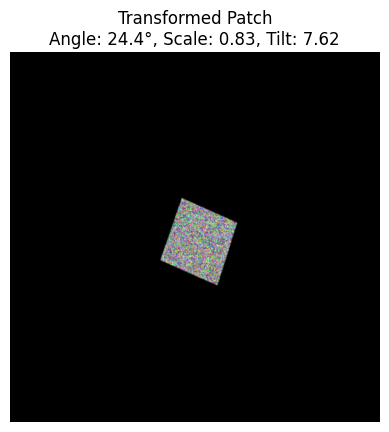

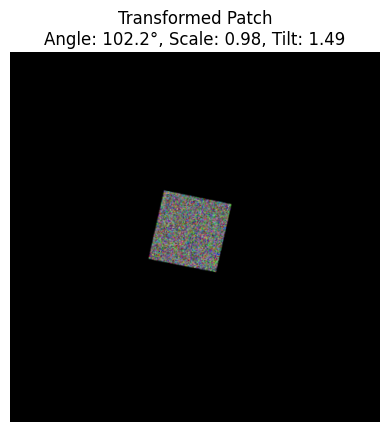

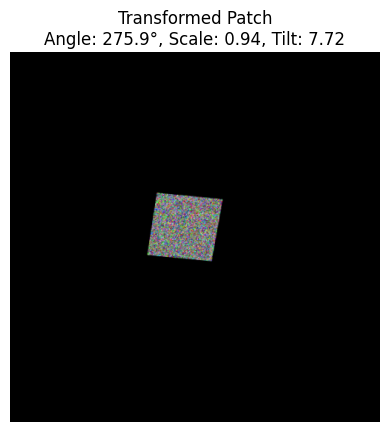

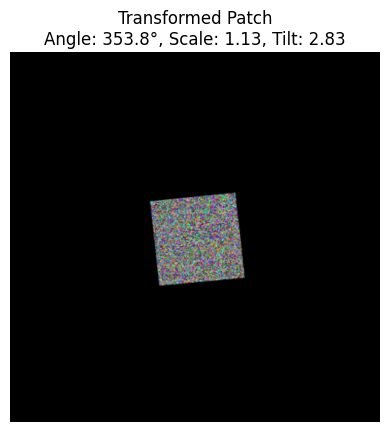

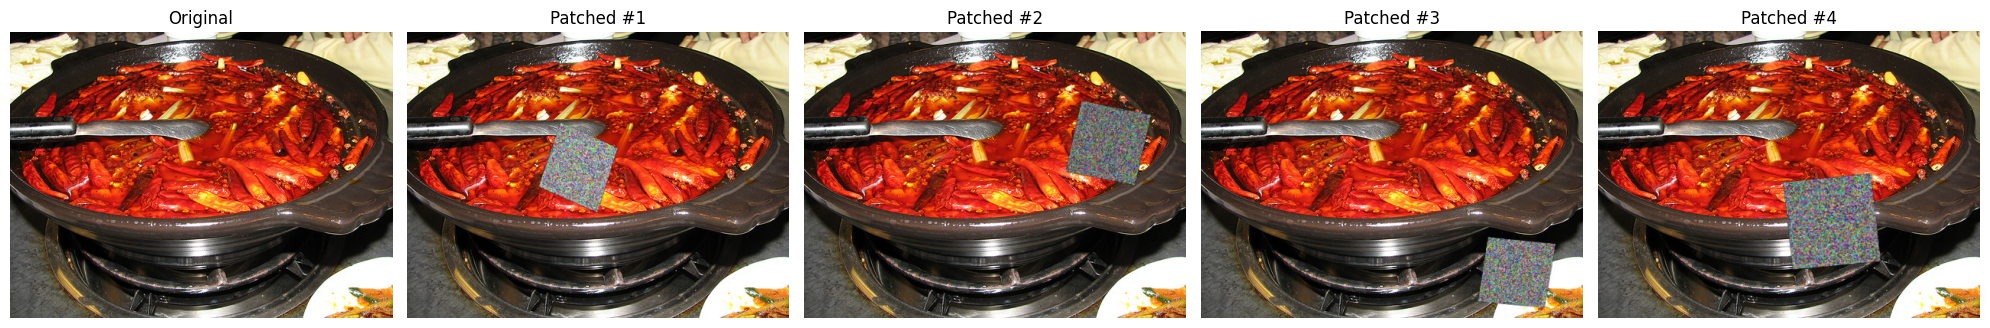

In [ ]:
# Get a random image from the training set
image_tensor, label = random.choice(train_dataset)
print("Image tensor data type: ", image_tensor.dtype)
image_tensor = image_tensor.unsqueeze(0).to(device)  # Add batch dimension

# Convert to CPU for visualization
def to_pil(tensor):
    return TF.to_pil_image(tensor.squeeze().cpu().clamp(0, 1))

# Generate 4 patched versions
patched_images = []
for _ in range(4):
    patched = random_overlay_patch(image_tensor, patch)
    patched_images.append(to_pil(patched))

# Plot original + patched images
fig, axes = plt.subplots(1, 5, figsize=(20, 5))
axes[0].imshow(to_pil(image_tensor.squeeze(0)))
axes[0].set_title("Original")
for i in range(4):
    axes[i+1].imshow(patched_images[i])
    axes[i+1].set_title(f"Patched #{i+1}")
for ax in axes:
    ax.axis("off")
plt.tight_layout()
plt.show()

In [ ]:
import time
import torch.nn.functional as F
runningVis = True
targeted = False
target_class = None
num_epochs = 5

def total_variation(x):
    # x: [B, C, H, W]
    tv_h = torch.mean(torch.abs(x[:, :, 1:, :] - x[:, :, :-1, :]))
    tv_w = torch.mean(torch.abs(x[:, :, :, 1:] - x[:, :, :, :-1]))
    return tv_h + tv_w

def patch_regularization(patch, tv_weight=0.001, l2_weight=0.0005):
    # Encourage smoothness and keep values bounded
    tv_loss = tv_weight * total_variation(patch)
    l2_loss = l2_weight * (patch**2).mean()
    return tv_loss + l2_loss

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
optimizer = torch.optim.Adam([patch], lr=0.01)
def train_adversarial_patch(model, dataset, batch_size=32, num_epochs=5):
    global patch
    model.eval()
    last_vis_time = time.time()

    for epoch in tqdm(range(num_epochs)):
        running_loss = 0.0
        patched_batch = []
        label_batch = []

        for i, (img, label) in enumerate(dataset):
            #print("On image ", i)
            img = img.unsqueeze(0).to(device)   # [1, C, H, W]
            label = torch.tensor([label], device=device)

            # Overlay patch first
            patched_img = random_overlay_patch(img, patch)

            # Preprocess AFTER patching
            patched_img = preprocess(patched_img.squeeze(0)).unsqueeze(0)

            patched_batch.append(patched_img)
            label_batch.append(label)

            # When we’ve collected a batch, run it
            if len(patched_batch) == batch_size:
                batch_tensor = torch.cat(patched_batch, dim=0).to(device)
                batch_labels = torch.cat(label_batch, dim=0).to(device)

                logits = model(batch_tensor)

                if targeted:
                    target_labels = torch.full_like(batch_labels, fill_value=target_class)
                    loss_main = F.cross_entropy(logits, target_labels)
                else:
                    loss_main = -F.cross_entropy(logits, batch_labels)

                loss_reg = patch_regularization(patch)
                loss = loss_main + loss_reg

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                patch.data.clamp_(0, 1)

                running_loss += loss.item()

                # Reset batch buffers
                patched_batch, label_batch = [], []

                # --- Visualization every 10 seconds ---
                if time.time() - last_vis_time > 10 and runningVis:
                    print("Patch so far:")
                    with torch.no_grad():
                        
                        plt.figure(figsize=(3, 3))
                        plt.imshow(patch[0].detach().cpu().permute(1, 2, 0).clamp(0, 1).numpy())
                        plt.title(f"Patch update (epoch {epoch+1}, step {i})")
                        plt.axis("off")
                        #plt.show()
                        plt.savefig(f"./images/patch_epoch{epoch+1}_step{i}.png")
                    last_vis_time = time.time()

        print(f"Epoch {epoch+1}/{num_epochs} - loss: {running_loss:.4f}")

        # Visualize patch
        with torch.no_grad():
            plt.figure(figsize=(3, 3))
            plt.imshow(patch[0].detach().cpu().permute(1, 2, 0).clamp(0, 1).numpy())
            plt.title(f"Patch after epoch {epoch+1}")
            plt.axis("off")
            #plt.show()
            plt.savefig(f"./images/patch_after_epoch{epoch+1}.png")

    return patch
train_adversarial_patch(model, train_dataset)